# 0. Load Libraries

In [1]:
import numpy as np
import os
import json
import pandas as pd
import models
import utils
from matplotlib import pyplot as plt
from classes import  Locatable, Satellite, Cluster, Vehicle
from drawingmap import DrawingMap

# 1. Load Data

## 1.1. Satellites

In [2]:
satellites, df_satellites = utils.LoadingData.load_satellites(DEBUG=False)
print(f'Cantidad de satellites cargados: {len(satellites)}')

Cantidad de satellites cargados: 9


## 1.2. Customer Clusters

In [3]:
clusters, df_clusters = utils.LoadingData.load_customer_clusters(DEBUG=False)
print(f'Cantidad de clusters cargados: {len(clusters)}')

Cantidad de clusters cargados: 721


## 1.3. Load Vehicles

In [4]:
small_vehicle = Vehicle(id='small'
                        , type='small'
                        , capacity=12
                        , costFixed=2
                        , time_service=0.05
                        , time_fixed=0.05
                        , time_load=0.0072
                        , time_dispatch=0.625
                        , speed_line=60
                        , Tmax=12
                        , k=1.3)
large_vehicle = Vehicle(id='large'
                        , type='large'
                        , capacity=53
                        , costFixed=10
                        , time_service=0.05
                        , time_fixed=0.05
                        , time_load=0.0142
                        , time_dispatch=0.75
                        , speed_line=80
                        , Tmax=12
                        , k=1)

## 1.4. Load Matrixes: Distance and Durations with and without traffic

### 1.4.1. From Satellites to Clusters

In [5]:
matrixes_from_satellites = utils.LoadingData.load_distances_duration_matrix_from_satellite()

### 1.4.2. From DC to Clusters

In [6]:
matrixes_from_dc = utils.LoadingData.load_distances_duration_matrix_from_dc()

# 2. Drawing Map

## 2.1. La Paz with customer segments

In [43]:
location_la_paz = (-16.501457, -68.149887)
location_DC = (-16.5354544, -68.1958506)

drawer = DrawingMap(location_la_paz)

drawer.addNodes(list_locatables=list(clusters.values()), color="blue", radius=1)
drawer.addNodes(list_locatables=list(satellites.values()), color='red', radius=3)
drawer.addMarker(location=location_DC, label='DC')

map = drawer.viewMap()
map

# 3. Generate Params

In [8]:
periods = 12

params_gurobi = {
    'TimeLimit':3600,
    'MIPGap':0.00
}

## 3.1. Average Fleet Size
#### a) From Satellite to Customer Cluster

In [9]:
config_ = utils.ConfigDeterministic()
fleet_size_satellites = config_.calculate_avg_fleet_size_from_satellites(satellites=list(satellites.values())
                                                                         , clusters=list(clusters.values())
                                                                         , vehicle=small_vehicle
                                                                         ,periods=periods, distances_linehaul=matrixes_from_satellites['distance'])

#### b) From DC to Customer Cluster

In [10]:
fleet_size_dc = config_.calculate_avg_fleet_size_from_dc(clusters=clusters.values(), vehicle=large_vehicle, periods=periods
                                                         , distances_linehaul=matrixes_from_dc['distance'])

In [11]:
fleet_size_required = {
    'small': fleet_size_satellites,
    'large': fleet_size_dc
}

## 3.3. Cost *$c_{sk}^{t}$* and *$g_{k}{t}$*

In [12]:
distance_average_from_satellites = {}
for s in satellites.values():
    sum_distances = 0
    count_records = 0
    for k in clusters.values():
        sum_distances+=matrixes_from_satellites['distance'][(s.id, k.id)]
        count_records=count_records+1
    avg_distance = sum_distances/count_records
    distance_average_from_satellites[s.id] = avg_distance
distance_average_from_satellites

{'Abaroa': 7.163305131761442,
 'Llojeta': 9.200861303744794,
 'Cota Cota': 10.82359778085992,
 'Achachicala': 8.87314285714286,
 'Mallasa': 12.356907073509012,
 'Sopocachi': 7.580083217753125,
 'Perferica': 8.806714285714287,
 'Zona Cementerio': 9.16176976421637,
 'Los Pinos': 8.961859916782249}

In [13]:
distance_average_from_dc = 0
sum_distances = 0
count_records = 0
for k in clusters.values():
    sum_distances+=matrixes_from_dc['distance'][k.id]
    count_records=count_records+1
avg_distance = sum_distances/count_records
distance_average_from_dc = avg_distance
distance_average_from_dc

18.852235783633862

In [14]:
# cost of shipping
fee_cost_from_satellites = 0.071 #0.071
fee_cost_from_dc = 0.25 #0.06 #

cost_shipping_from_satellites = dict([
    ((s.id, k.id),fee_cost_from_satellites*matrixes_from_satellites['distance'][(s.id, k.id)]/distance_average_from_satellites[s.id])
    if matrixes_from_satellites['distance'][(s.id, k.id)]/distance_average_from_satellites[s.id] > 0.5 else ((s.id, k.id),fee_cost_from_satellites*0.5)
    for s in satellites.values() for k in clusters.values()
])


cost_shipping_from_dc = dict([
    ((k.id),fee_cost_from_dc*matrixes_from_dc['distance'][k.id]/distance_average_from_dc)
    if matrixes_from_dc['distance'][k.id]/distance_average_from_dc> 0.5 else ((k.id),fee_cost_from_dc*0.5)
    for k in clusters.values()
])

In [15]:
def cost_satellite_cluster_period(satellites: list[Satellite],
                                  clusters: list[Cluster],
                                  cost_shipping: dict[(str, str), float],
                                  vehicle_small: Vehicle,
                                  periods: int,
                                  vehicles_required: dict[str, dict]) -> dict[(str,str,int), float]:
    costs = {}
    for t in range(periods):
        for k in clusters:
            for s in satellites:
                costs[(s.id, k.id, t)] = (s.costSourcing*k.demandByPeriod[t]) + (cost_shipping[(s.id, k.id)]*k.demandByPeriod[t]) + \
                                         (vehicle_small.costFixed*vehicles_required['small'][(s.id, k.id, t)])
    return costs

def cost_dc_cluster_period(clusters: list[Cluster],
                           cost_shipping: dict[str, float],
                           vehicle_large: Vehicle,
                           periods: int,
                           vehicles_required: dict[str, dict]) -> dict[(str,int), float]:
    costs = {}
    for t in range(periods):
        for k in clusters:
            costs[(k.id, t)] = (cost_shipping[k.id] * k.demandByPeriod[t]) + (vehicle_large.costFixed * vehicles_required['large'][(k.id, t)])
    return costs

In [16]:
cost_C = cost_satellite_cluster_period(satellites.values(), clusters.values()
                                       ,cost_shipping=cost_shipping_from_satellites
                                       ,vehicle_small=small_vehicle
                                       ,periods=periods
                                       ,vehicles_required=fleet_size_required)

cost_G = cost_dc_cluster_period(clusters.values()
                                ,cost_shipping=cost_shipping_from_dc
                                ,vehicle_large=large_vehicle
                                ,periods=periods
                                ,vehicles_required=fleet_size_required)
cost_operation = {
    'satellite': cost_C,
    'dc': cost_G
}

max: 46.998506594033095 - min: 0.03466973993351724 - mean 1.4102403421407128


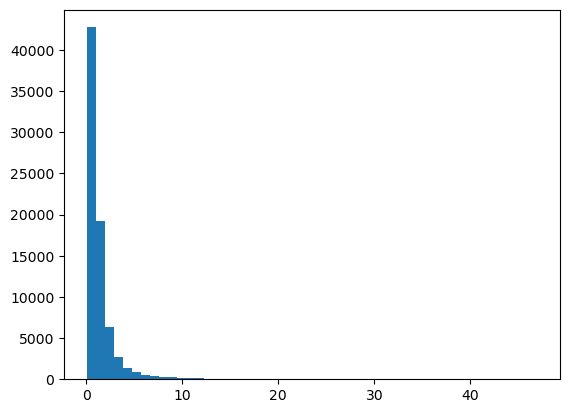

In [17]:
cost_shipping_satellites = [item for item in list(cost_C.values()) if item!=0]
print(f'max: {np.max(cost_shipping_satellites)} - min: {np.min(cost_shipping_satellites)} - mean {np.mean(cost_shipping_satellites)}')
plt.hist(cost_shipping_satellites, bins=50)
plt.show()

max: 71.92939303354615 - min: 0.10996979773594834 - mean 2.6310183150250497


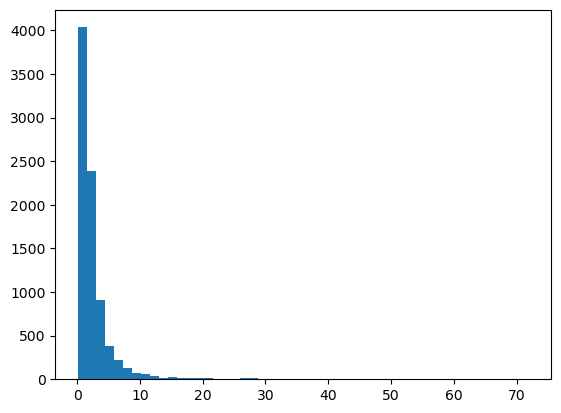

In [18]:
cost_shipping_dc = [item for item in list(cost_G.values()) if item!=0]
print(f'max: {np.max(cost_shipping_dc)} - min: {np.min(cost_shipping_dc)} - mean {np.mean(cost_shipping_dc)}')
plt.hist(cost_shipping_dc, bins=50)
plt.show()

# 4. Model Deterministic

In [19]:
model_ = models.ModelDeterministic(periods=periods)
model_.setParams(params=params_gurobi)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-13
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0


In [20]:
model_.build(satellites=list(satellites.values())
             ,clusters=list(clusters.values())
             ,vehicles_required=fleet_size_required
             ,costs=cost_operation)

Discarded solution information


{'time_building': 1}

In [21]:
print(model_.optimizeModel())

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 86745 rows, 86682 columns and 319404 nonzeros
Model fingerprint: 0x8fe11ef9
Variable types: 0 continuous, 86682 integer (86682 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+01]
  Objective range  [3e-02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 22126.864029
Presolve removed 6646 rows and 15056 columns
Presolve time: 0.45s
Presolved: 80099 rows, 71626 columns, 287116 nonzeros
Variable types: 0 continuous, 71626 integer (71626 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   76198    1.2583813e+04   0.000000e+00   9.048193e+04      5s
   80867    1.2570336e+04   0.000000e+00   1.107

In [22]:
cost_allocation_satellites = np.sum([
    (s.costFixed[q_id]/30) * model_.Y[(s.id, q_id)].x for s in list(satellites.values()) for q_id in s.capacity.keys()
])

cost_operating_satellites = np.sum([
    (s.costOperation[t]/30) * model_.X[(s.id, t)].x for s in list(satellites.values()) for t in range(periods)
])

cost_served_from_satellite = np.sum([
    cost_operation['satellite'][(s.id, k.id, t)] * model_.Z[(s.id, k.id, t)].x for s in list(satellites.values()) for k in
    list(clusters.values()) for t in
    range(periods)
])

cost_served_from_dc = np.sum([
    cost_operation['dc'][(k.id, t)] * model_.W[(k.id, t)].x for k in list(clusters.values()) for t in range(periods)
])

In [23]:
cost_allocation_satellites

333.33333333333337

In [24]:
cost_operating_satellites

1474.5666666666666

In [25]:
cost_served_from_satellite

9441.172647191053

In [26]:
cost_served_from_dc

94.31027995683849

## 4.1. Get results

In [27]:
variables_results = model_.get_results(satellites=list(satellites.values())
                                      ,clusters=list(clusters.values()))

### 4.1.1. Y

In [28]:
for k, v in variables_results['Y'].items():
    print(f'id: {v.id} cap: {k[1]}')

id: Achachicala cap: 7
id: Los Pinos cap: 5


### 4.1.2. X

In [29]:
for t in range(periods):
    print(f'###### t - {t}', end=" ")
    for k, v in variables_results['X'][t].items():
        print(f'id: {v.id}', end=" | ")
    print("")

###### t - 0 id: Achachicala | id: Los Pinos | 
###### t - 1 id: Achachicala | id: Los Pinos | 
###### t - 2 id: Achachicala | id: Los Pinos | 
###### t - 3 id: Achachicala | id: Los Pinos | 
###### t - 4 id: Achachicala | id: Los Pinos | 
###### t - 5 id: Achachicala | id: Los Pinos | 
###### t - 6 id: Achachicala | id: Los Pinos | 
###### t - 7 id: Achachicala | id: Los Pinos | 
###### t - 8 id: Achachicala | id: Los Pinos | 
###### t - 9 id: Achachicala | id: Los Pinos | 
###### t - 10 id: Achachicala | id: Los Pinos | 
###### t - 11 id: Achachicala | id: Los Pinos | 


### 4.1.3. W

In [30]:
period_selected = 1
lista_clusters = variables_results['W'][period_selected]

# map
location_la_paz = (-16.501457, -68.149887)
location_DC = (-16.5354544, -68.1958506)
drawer = DrawingMap(location_la_paz)
drawer.addNodes(list_locatables=lista_clusters, color="blue", radius=3)
drawer.addMarker(location=location_DC, label='DC')
map = drawer.viewMap()
map

### 4.1.4 Z

In [31]:
map_colors = {
    'Abaroa': 'blue',
    'Llojeta': 'green',
    'Cota Cota': 'orange',
    'Achachicala': 'darkgreen',
    'Mallasa': 'black',
    'Sopocachi': 'gray',
    'Perferica': 'darkred',
    'Zona Cementerio': 'pink',
    'Los Pinos': 'purple'
}

In [32]:
period_selected = 0
location_la_paz = (-16.501457, -68.149887)
location_DC = (-16.5354544, -68.1958506)
drawer = DrawingMap(location_la_paz)
for k, v in map_colors.items():
    satellite_selected = k
    lista_clusters = variables_results['Z'][period_selected][satellite_selected]
    if len(lista_clusters) == 0:
        continue
    # map
    drawer.addNodes(list_locatables=lista_clusters, color=v, radius=3)
    #drawer.addNode(location=(satellites[satellite_selected].lat, satellites[satellite_selected].lon), color=v, radius=4)
    drawer.addMarker(location=(satellites[satellite_selected].lat, satellites[satellite_selected].lon), label=satellite_selected)


drawer.addMarker(location=location_DC, label='DC')
map = drawer.viewMap()
map

In [33]:
#period_selected = 1
#satellite_selected = "Abaroa"
#lista_clusters = variables_results['Z'][period_selected][satellite_selected]
## map
#location_la_paz = (-16.501457, -68.149887)
#location_DC = (-16.5354544, -68.1958506)
#drawer = DrawingMap(location_la_paz)
#drawer.addNodes(list_locatables=lista_clusters, color="blue", radius=1)
#drawer.addNode(location=(satellites[satellite_selected].lat, satellites[satellite_selected].lon), color='red', radius=3)
#drawer.addMarker(location=location_DC, label='DC')
#
#map = drawer.viewMap()
#map

## 4.2. Metrics

### 4.2.1. Vehicles Required

In [34]:
def obtain_vehicles_required_in_satellite(satellite: Satellite, clusters_served: list[Cluster], period: int, vehicles_required: dict[(str, str, t), float]):
    vehicles_sum = 0
    for c in clusters_served:
        vehicles_sum += vehicles_required[(satellite.id, c.id, period)]
    return vehicles_sum
vehicles_required_results = dict([
    (s.id, [obtain_vehicles_required_in_satellite(s
                                     ,clusters_served=variables_results['Z'][t][s.id]
                                     ,period=t
                                     ,vehicles_required=fleet_size_satellites) for t in range(periods)]) for s in list(satellites.values())
])
print(json.dumps(vehicles_required_results, indent=2))

{
  "Abaroa": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "Llojeta": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "Cota Cota": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "Achachicala": [
    6.904987849267691,
    6.999787907505315,
    6.589764029287796,
    5.589910466366084,
    5.781292928437445,
    6.920109148799454,
    6.689659046443116,
    5.882744483115209,
    6.731008932664669,
    6.999537670706974,
    6.999945687417545,
    6.999988651653569
  ],
  "Mallasa": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "Sopocachi": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "Perferica": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "Zona Cementerio": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    

In [35]:
def obtain_vehicles_required_in_dc(clusters_served: list[Cluster], period: int, vehicles_required: dict[(str, t), float]):
    vehicles_sum = 0
    for c in clusters_served:
        vehicles_sum += vehicles_required[(c.id, period)]
    return vehicles_sum

vehicles_required_results =[ obtain_vehicles_required_in_dc(clusters_served=variables_results['W'][t]
                                                  ,period=t
                                                  ,vehicles_required=fleet_size_dc) for t in range(periods)
]
print(json.dumps(vehicles_required_results, indent=2))

[
  0.01280733094909957,
  0.010786898360382699,
  0.009873282973139831,
  0.0,
  0.009010040269308569,
  0.007131283367744181,
  0.004268135365889759,
  0.0,
  0.0052690288874961706,
  0.1514173060579336,
  0.14627848241816674,
  0.27061621343271935
]


In [36]:
for item in variables_results['W'][11]:
    print(f'cluster_s{item.id} _fleet: {fleet_size_dc[(item.id, 11)]}')

cluster_s89b3219900bffff _fleet: 0.0
cluster_s89b3219909bffff _fleet: 0.0
cluster_s89b3219914fffff _fleet: 0.0
cluster_s89b321992a3ffff _fleet: 0.0
cluster_s89b32199337ffff _fleet: 0.0
cluster_s89b32199407ffff _fleet: 0.0
cluster_s89b32199443ffff _fleet: 0.0
cluster_s89b321995d3ffff _fleet: 0.0
cluster_s89b321996b7ffff _fleet: 0.0
cluster_s89b32199813ffff _fleet: 0.0
cluster_s89b32199a93ffff _fleet: 0.0
cluster_s89b32199d23ffff _fleet: 0.0
cluster_s89b32199d2bffff _fleet: 0.0
cluster_s89b32199d53ffff _fleet: 0.0
cluster_s89b32199d8bffff _fleet: 0.0
cluster_s89b32199e47ffff _fleet: 0.0
cluster_s89b32199e67ffff _fleet: 0.0
cluster_s89b32199e6bffff _fleet: 0.0
cluster_s89b32199e6fffff _fleet: 0.0
cluster_s89b321d602bffff _fleet: 0.014725116916374502
cluster_s89b321d6067ffff _fleet: 0.005566612952095658
cluster_s89b321d6077ffff _fleet: 0.01069098978853159
cluster_s89b321d614bffff _fleet: 0.0036072116043725025
cluster_s89b321d615bffff _fleet: 0.0017565350709506822
cluster_s89b321d616bffff _

In [37]:
#clusters['89b3219900bffff'].__dict__

In [38]:
#cost_G[('89b3219900bffff',11)]

### 4.2.2. % Demand served from Satellites

In [39]:
demand_by_period = []
for t in range(periods):
    sum_ = 0
    for c in list(clusters.values()):
        sum_ += c.demandByPeriod[t]
    demand_by_period.append(sum_)

In [40]:
demand_by_period

[7490.139,
 7730.235000000004,
 6952.625000000003,
 6255.008999999998,
 6568.841000000002,
 7486.1680000000015,
 7284.494000000004,
 6459.2440000000015,
 7405.661999999996,
 8338.718999999997,
 8511.544999999996,
 9067.305]

In [41]:
resumen ={}
for s in list(satellites.values()):
    demand_served = []
    for t in range(periods):
        sum_ = 0
        for c in variables_results['Z'][t][s.id]:
            sum_ += c.demandByPeriod[t]
        demand_served.append(sum_)
    per_demand_served = np.array(demand_served) / np.array(demand_by_period)
    resumen[s.id] = {
        'demand_served': demand_served,
        'per_demand_served': per_demand_served.tolist()
    }
print("FROM SATELLITES: ")
print(json.dumps(resumen, indent=2))

FROM SATELLITES: 
{
  "Abaroa": {
    "demand_served": [
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0
    ],
    "per_demand_served": [
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0
    ]
  },
  "Llojeta": {
    "demand_served": [
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0
    ],
    "per_demand_served": [
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0
    ]
  },
  "Cota Cota": {
    "demand_served": [
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0
    ],
    "per_demand_served": [
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0
    ]
  },
  "Achachicala":

### 4.2.3. % Demand served from DC

In [42]:
demand_served = []
for t in range(periods):
    sum_ = 0
    for c in variables_results['W'][t]:
        sum_ += c.demandByPeriod[t]
    demand_served.append(sum_)
per_demand_served = np.array(demand_served) / np.array(demand_by_period)
resumen = {
    'demand_served': demand_served,
    'per_demand_served': per_demand_served.tolist()
}
print("FROM DC: ")
print(json.dumps(resumen, indent=2))

FROM DC: 
{
  "demand_served": [
    13.25,
    10.875,
    9.812,
    0.0,
    9.8,
    6.625,
    4.0,
    0.0,
    4.722,
    173.28800000000004,
    149.808,
    299.142
  ],
  "per_demand_served": [
    0.0017689925380557023,
    0.0014068136350317932,
    0.001411265529206594,
    0.0,
    0.0014918917964371488,
    0.0008849654456058157,
    0.0005491115786491138,
    0.0,
    0.0006376202424577307,
    0.02078112957158049,
    0.017600564879819123,
    0.03299128020949996
  ]
}
